In [2]:
import pandas as pd #Data manipulation
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph.
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
#import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# ===============================================
# 🧹 LOAD & CLEAN MOVIE DATA FROM TXT FILE
# ===============================================

import pandas as pd
import re

# Path to your text file (update as needed)
file_path = 'train_data.txt'  # Example: stored in Colab or Drive

# Read the raw file
with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
    lines = f.readlines()

print(f"Total raw lines read: {len(lines)}")

# Remove empty or whitespace-only lines
lines = [line.strip() for line in lines if line.strip()]

# Optional sanity check: show a few samples
print("\nSample lines:\n", lines[:3])

# -----------------------------------------------
# Clean and split lines safely
# -----------------------------------------------
cleaned_rows = []
for line in lines:
    # Each valid row should have 4 parts separated by ':::'
    parts = [p.strip() for p in line.split(":::")]
    if len(parts) == 4:
        cleaned_rows.append(parts)
    else:
        # Handle malformed lines by skipping or fixing
        # You could also use regex fallback if needed
        continue

print(f"Valid records after cleaning: {len(cleaned_rows)}")

# Create DataFrame
df = pd.DataFrame(cleaned_rows, columns=['id', 'title', 'genre', 'description'])

# -----------------------------------------------
# Clean column contents
# -----------------------------------------------
# Convert IDs to integer where possible
df['id'] = df['id'].apply(lambda x: re.sub(r'[^0-9]', '', x)).astype(int)

# Strip extra spaces and quotes
for col in ['title', 'genre', 'description']:
    df[col] = df[col].astype(str).str.strip().str.replace(r'["“”]', '', regex=True)

# Drop duplicates or rows with missing text
df = df.dropna(subset=['description', 'genre'])
df = df.drop_duplicates(subset=['title', 'description'])

print("\nAfter cleaning:")
print(df.info())
print(df.head(3))

# Save to CSV (optional, for reuse)
# df.to_csv('/content/clean_movie_dataset.csv', index=False)


Total raw lines read: 54214

Sample lines:
 ['1 ::: Oscar et la dame rose (2009) ::: drama ::: Listening in to a conversation between his doctor and parents, 10-year-old Oscar learns what nobody has the courage to tell him. He only has a few weeks to live. Furious, he refuses to speak to anyone except straight-talking Rose, the lady in pink he meets on the hospital stairs. As Christmas approaches, Rose uses her fantastical experiences as a professional wrestler, her imagination, wit and charm to allow Oscar to live life and love to the full, in the company of his friends Pop Corn, Einstein, Bacon and childhood sweetheart Peggy Blue.', '2 ::: Cupid (1997) ::: thriller ::: A brother and sister with a past incestuous relationship have a current murderous relationship. He murders the women who reject him and she murders the women who get too close to him.', '3 ::: Young, Wild and Wonderful (1980) ::: adult ::: As the bus empties the students for their field trip to the Museum of Natural Hi


✅ Total unique genres in dataset: 27

Genres:
 ['drama' 'thriller' 'adult' 'documentary' 'comedy' 'crime' 'reality-tv'
 'horror' 'sport' 'animation' 'action' 'fantasy' 'short' 'sci-fi' 'music'
 'adventure' 'talk-show' 'western' 'family' 'mystery' 'history' 'news'
 'biography' 'romance' 'game-show' 'musical' 'war']


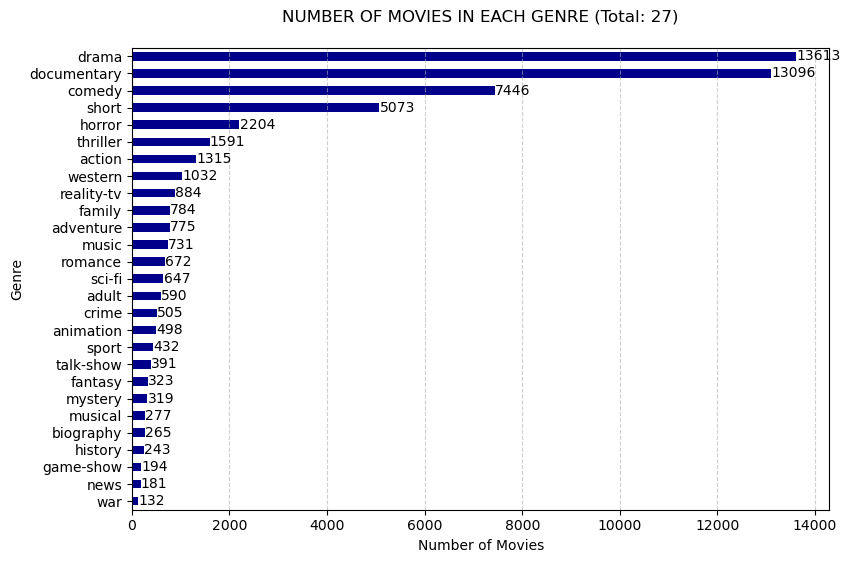

In [4]:
# ==========================================
# 🔍 EXPLORATION & ENCODING (updated)
# ==========================================

# Encode genres into numeric IDs
df['genre_id'] = df['genre'].factorize()[0]
category_id_df = df[['genre', 'genre_id']].drop_duplicates()
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['genre_id', 'genre']].values)

# Count number of unique genres
num_genres = df['genre'].nunique()
print(f"\n✅ Total unique genres in dataset: {num_genres}")
print("\nGenres:\n", df['genre'].unique())

# Plot number of samples per genre
fig = plt.figure(figsize=(9,6))
genre_counts = df.groupby('genre').description.count().sort_values()

# Add total number of genres to the title
genre_counts.plot.barh(
    color='darkblue',
    title=f'NUMBER OF MOVIES IN EACH GENRE (Total: {num_genres})\n'
)
plt.xlabel('Number of Movies', fontsize=10)
plt.ylabel('Genre', fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Add labels to bars
for i, v in enumerate(genre_counts):
    plt.text(v + 1, i, str(v), color='black', va='center')

plt.show()

In [5]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=2,
                        stop_words='english', ngram_range=(1,2))
features = tfidf.fit_transform(df['title'])
labels = df['genre_id']

print(f"Each of the {features.shape[0]} movies is represented by {features.shape[1]} features (TF-IDF scores)")


Each of the 54213 movies is represented by 20944 features (TF-IDF scores)


In [6]:
N = 3
for genre, genre_id in sorted(category_to_id.items()):
    chi2_vals = chi2(features, labels == genre_id)
    indices = np.argsort(chi2_vals[0])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print(f"\n==> {genre.upper()}:")
    print("  * Most correlated unigrams:", ', '.join(unigrams[-N:]))
    print("  * Most correlated bigrams:", ', '.join(bigrams[-N:]))


==> ACTION:
  * Most correlated unigrams: daku, wwf, ninja
  * Most correlated bigrams: ninja vixens, wwf house, shao lin

==> ADULT:
  * Most correlated unigrams: private, indieboyz, xxx
  * Most correlated bigrams: private gold, bad girls, grab bind

==> ADVENTURE:
  * Most correlated unigrams: tarzan, kidnapping, bondage
  * Most correlated bigrams: cultures die, tales 2002, sam max

==> ANIMATION:
  * Most correlated unigrams: chhota, bratz, bheem
  * Most correlated bigrams: beast 1992, chhota bheem, monster high

==> BIOGRAPHY:
  * Most correlated unigrams: resolve, gogol, käthe
  * Most correlated bigrams: stars 2011, life party, life marilyn

==> COMEDY:
  * Most correlated unigrams: movie, bikini, comedy
  * Most correlated bigrams: bash maystorat, girl 2011, recep ivedik

==> CRIME:
  * Most correlated unigrams: banchô, taygi, ermittelt
  * Most correlated bigrams: arne dahl, krimi 2016, london 2018

==> DOCUMENTARY:
  * Most correlated unigrams: documentary, story, making
 

In [7]:
X_train, X_test, y_train, y_test = train_test_split(features, labels,
                                                    test_size=0.25,
                                                    random_state=42)


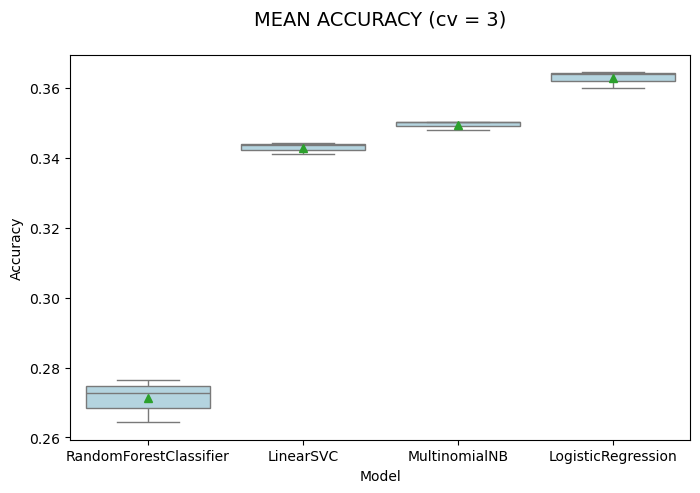

                        Accuracy  Accuracy
Model                                     
LinearSVC               0.342999  0.001664
LogisticRegression      0.362939  0.002438
MultinomialNB           0.349547  0.001279
RandomForestClassifier  0.271190  0.006244


In [8]:
models = [
    RandomForestClassifier(n_estimators=50, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(max_iter=1000, random_state=0)
]

CV = 3
entries = []

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['Model', 'Fold', 'Accuracy'])

# Boxplot of accuracies
plt.figure(figsize=(8,5))
sns.boxplot(x='Model', y='Accuracy', data=cv_df, color='lightblue', showmeans=True)
plt.title("MEAN ACCURACY (cv = 3)\n", size=14)
plt.show()

mean_acc = cv_df.groupby('Model').Accuracy.mean()
std_acc = cv_df.groupby('Model').Accuracy.std()
print(pd.concat([mean_acc, std_acc], axis=1).rename(columns={0:'Mean',1:'StdDev'}))



		CLASSIFICATION REPORT

              precision    recall  f1-score   support

       drama       0.36      0.52      0.42      3384
    thriller       0.12      0.07      0.09       384
       adult       0.31      0.16      0.21       135
 documentary       0.42      0.51      0.46      3294
      comedy       0.26      0.22      0.24      1810
       crime       0.11      0.03      0.04       143
  reality-tv       0.13      0.09      0.10       223
      horror       0.36      0.31      0.33       531
       sport       0.41      0.31      0.35       109
   animation       0.14      0.06      0.09       128
      action       0.17      0.11      0.13       338
     fantasy       0.04      0.01      0.02        90
       short       0.24      0.15      0.18      1338
      sci-fi       0.15      0.06      0.09       180
       music       0.41      0.29      0.34       179
   adventure       0.17      0.10      0.13       177
   talk-show       0.23      0.09      0.13        97


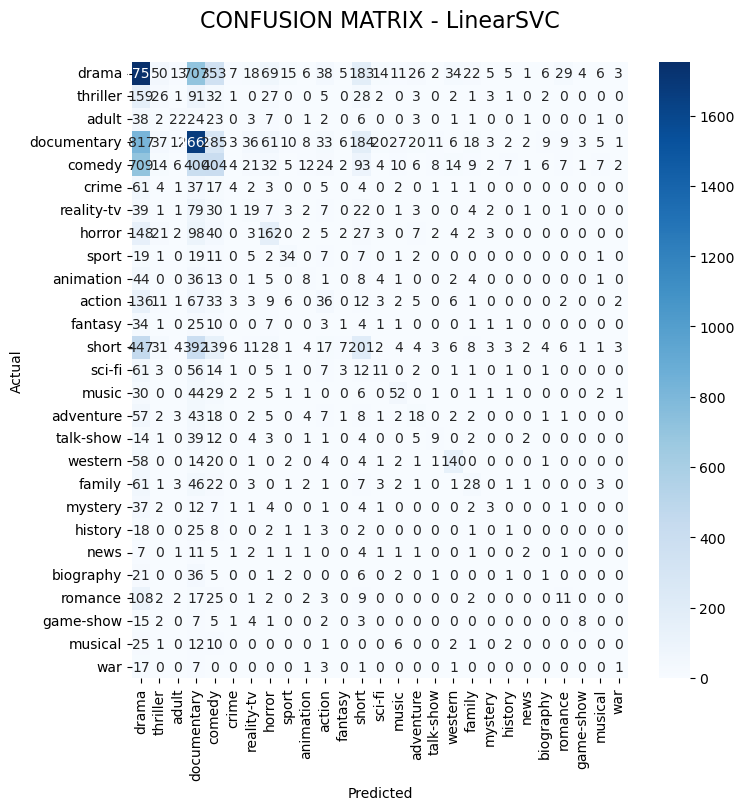

In [9]:
# ==========================================================
# 🧠 MODEL TRAINING AND PREDICTION
# ==========================================================
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train the model
model = LinearSVC()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Classification report
print("\n\n\t\tCLASSIFICATION REPORT\n")
print(classification_report(y_test, y_pred, target_names=df['genre'].unique()))

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=df['genre'].unique(),
            yticklabels=df['genre'].unique(), cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('CONFUSION MATRIX - LinearSVC\n', size=16)
plt.show()


In [10]:
for predicted in category_id_df.genre_id:
    for actual in category_id_df.genre_id:
        if predicted != actual and conf_mat[actual, predicted] >= 2:
            print(f"'{id_to_category[actual]}' predicted as '{id_to_category[predicted]}' : {conf_mat[actual, predicted]} examples.")

'thriller' predicted as 'drama' : 159 examples.
'adult' predicted as 'drama' : 38 examples.
'documentary' predicted as 'drama' : 817 examples.
'comedy' predicted as 'drama' : 709 examples.
'crime' predicted as 'drama' : 61 examples.
'reality-tv' predicted as 'drama' : 39 examples.
'horror' predicted as 'drama' : 148 examples.
'sport' predicted as 'drama' : 19 examples.
'animation' predicted as 'drama' : 44 examples.
'action' predicted as 'drama' : 136 examples.
'fantasy' predicted as 'drama' : 34 examples.
'short' predicted as 'drama' : 447 examples.
'sci-fi' predicted as 'drama' : 61 examples.
'music' predicted as 'drama' : 30 examples.
'adventure' predicted as 'drama' : 57 examples.
'talk-show' predicted as 'drama' : 14 examples.
'western' predicted as 'drama' : 58 examples.
'family' predicted as 'drama' : 61 examples.
'mystery' predicted as 'drama' : 37 examples.
'history' predicted as 'drama' : 18 examples.
'news' predicted as 'drama' : 7 examples.
'biography' predicted as 'drama' 

In [11]:
def predict_genre_from_title(movie_title):
    movie_features = tfidf.transform([movie_title])
    pred_id = model.predict(movie_features)[0]
    return id_to_category[pred_id]


In [15]:
movie_title = "Interstellar"
predicted_genre = predict_genre_from_title(movie_title)
print(f"The predicted genre for '{movie_title}' is: {predicted_genre}")


The predicted genre for 'Interstellar' is: documentary


combine data with low frequency and have few genres
Remove Stop words
Change the ngrams size 

Try to have more accuracy
Kaggle competition... on dec... grades are dependent
capstone project 
2 - class activities (paper and hands on)